In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, precision_score, recall_score, r2_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import optuna

from joblib import Parallel, delayed

# Регрессия

In [2]:
RAW_FEATS = 'regression_raw_feats.csv'
RAW_TARGET = 'regression_raw_target.csv'
PROCESSED_FEATS = 'regression_processed_feats.csv'
PROCESSED_TARGET = 'regression_processed_target.csv'

In [3]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [4]:
def evaluate(metrics, y_test, y_pred, round_num):
    for metric in metrics:
        print(f'Model score for metric "{metric.__name__}": {round(metric(y_test, y_pred), round_num)}')

    plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
    line_coords = np.linspace(np.min(y_test), np.max(y_test), 100)
    plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs predicted values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
eval_metrics = [mean_absolute_error, root_mean_squared_error, r2_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = root_mean_squared_error
optuna_direction = "minimize"
n_trials = 30
cv = 3

## Готовая модель

In [6]:
model_class = RandomForestRegressor

### Бейзлайн

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [8]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [9]:
model = model_class(random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [10]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.4521
Model score for metric "root_mean_squared_error": 4.5741
Model score for metric "r2_score": 0.5224


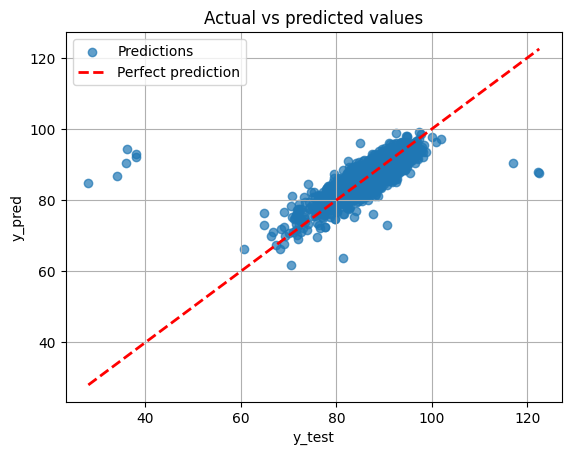

In [11]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [13]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [14]:
model = model_class(random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [15]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.3606
Model score for metric "root_mean_squared_error": 3.4451
Model score for metric "r2_score": 0.6283


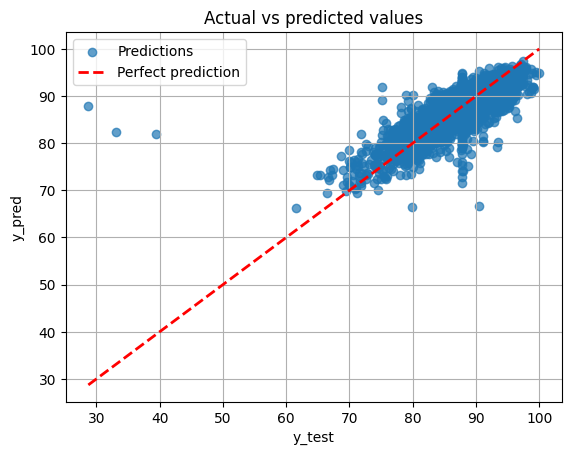

In [16]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [17]:
def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    else:
        max_samples = None

    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': bootstrap,
        'max_samples': max_samples,
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-10 21:17:26,591] A new study created in memory with name: no-name-5ab84fa8-20c6-4033-804f-3df010f69350
[I 2025-12-10 21:17:29,032] Trial 0 finished with value: 4.416961113349174 and parameters: {'bootstrap': False, 'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'squared_error', 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 4.416961113349174.
[I 2025-12-10 21:17:39,068] Trial 1 finished with value: 4.62457461827221 and parameters: {'bootstrap': True, 'max_samples': 0.6061695553391381, 'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None, 'criterion': 'absolute_error', 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 4.416961113349174.
[I 2025-12-10 21:18:22,180] Trial 2 finished with value: 4.654123448526737 and parameters: {'bootstrap': False, 'n_estimators': 247, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf

Лучшие параметры для модели: {'bootstrap': True, 'max_samples': 0.8911347493577076, 'n_estimators': 209, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'absolute_error', 'random_state': 42, 'n_jobs': -1}
Лучшая метрика (root_mean_squared_error): 4.369


RandomForestRegressor(criterion='absolute_error', max_depth=12,
                      max_features='sqrt', max_samples=0.8911347493577076,
                      min_samples_leaf=3, min_samples_split=4, n_estimators=209,
                      n_jobs=-1, random_state=42)

In [18]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.1472
Model score for metric "root_mean_squared_error": 3.1469
Model score for metric "r2_score": 0.6898


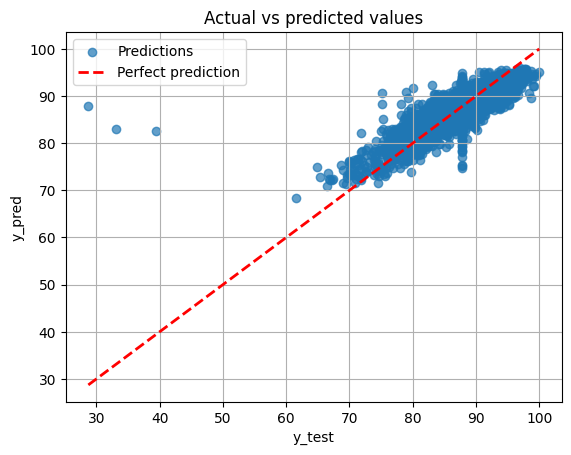

In [19]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

## Своя модель

In [ ]:
class MyRandomForestRegressor:
    """
    Parameters
    -----------
    n_estimators : int, default=100
    max_depth : int, default=None
    min_samples_split : int, default=2
    min_samples_leaf : int, default=1
    max_features : int, float, {"auto", "sqrt", "log2"} or None, default=None
    bootstrap : bool, default=True
    max_samples : int or float, default=None
    criterion : str, default="squared_error"
    random_state : int, default=None
    n_jobs : int, default=None
    """
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
            min_samples_leaf=1, max_features=None, bootstrap=True, 
            max_samples=None, criterion="squared_error", random_state=None, n_jobs=None):
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.criterion = criterion
        self.random_state = random_state
        self.n_jobs = n_jobs
        
        self.estimators_ = None
        self.n_features_ = None
        self.X_ = None
        self.y_ = None
        self.rng_ = None
    
    def fit(self, X, y):
        X = np.asarray(X, dtype = float)
        y = np.asarray(y, dtype = float)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")
        
        self.X_ = X
        self.y_ = y
        self.n_features_ = X.shape[1]
        
        self.rng_ = np.random.RandomState(self.random_state)
        
        self.estimators_ = []
        
        if self.max_features is None or self.max_features == "auto":
            max_features = self.n_features_
        elif self.max_features == "sqrt":
            max_features = max(1, int(np.sqrt(self.n_features_)))
        elif self.max_features == "log2":
            max_features = max(1, int(np.log2(self.n_features_)))
        elif isinstance(self.max_features, int):
            max_features = min(self.max_features, self.n_features_)
        elif isinstance(self.max_features, float):
            max_features = max(1, int(self.max_features * self.n_features_))
        
        if self.max_samples is None:
            max_samples = X.shape[0]
        elif isinstance(self.max_samples, int):
            max_samples = min(self.max_samples, X.shape[0])
        elif isinstance(self.max_samples, float):
            max_samples = max(1, int(self.max_samples * X.shape[0]))
        
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._build_tree)(
                max_features, max_samples, i
            ) for i in range(self.n_estimators)
        )
        
        return self
    
    def _build_tree(self, max_features, max_samples, tree_idx):
        tree = DecisionTreeRegressor(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=max_features,
            criterion=self.criterion,
            random_state=self.random_state + tree_idx if self.random_state is not None else None
        )
        
        if self.bootstrap:
            indices = self.rng_.choice(self.X_.shape[0], max_samples, replace=True)
        else:
            indices = self.rng_.choice(self.X_.shape[0], max_samples, replace=False)
        
        X_subset = self.X_[indices]
        y_subset = self.y_[indices]
        
        tree.fit(X_subset, y_subset)
        
        return tree
    
    def predict(self, X):
        if self.estimators_ is None:
            raise RuntimeError("You must call fit() before predict().")
        
        X = np.asarray(X)
        
        predictions = np.array([tree.predict(X) for tree in self.estimators_])
        
        return np.mean(predictions, axis=0)
    
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'max_samples': self.max_samples,
            'criterion': self.criterion,
            'random_state': self.random_state,
            'n_jobs': self.n_jobs
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyRandomForestRegressor")
        return self

In [21]:
model_class = MyRandomForestRegressor

### Бейзлайн

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [23]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [24]:
model = model_class(random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

In [25]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.0916
Model score for metric "root_mean_squared_error": 5.6386
Model score for metric "r2_score": 0.2742


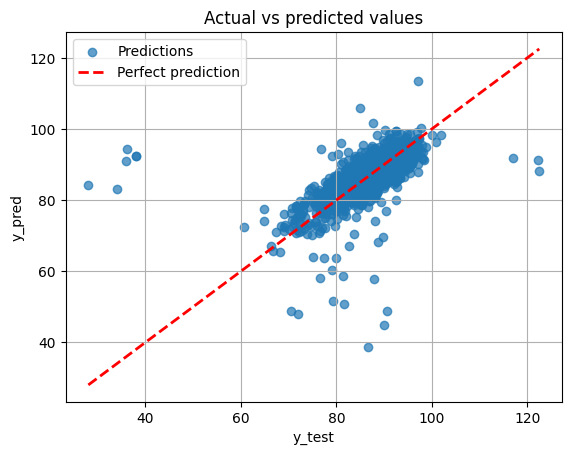

In [26]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты сильно хуже, чем у библиотечной модели.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [28]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [29]:
model = model_class(random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

In [30]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.9338
Model score for metric "root_mean_squared_error": 4.7493
Model score for metric "r2_score": 0.2936


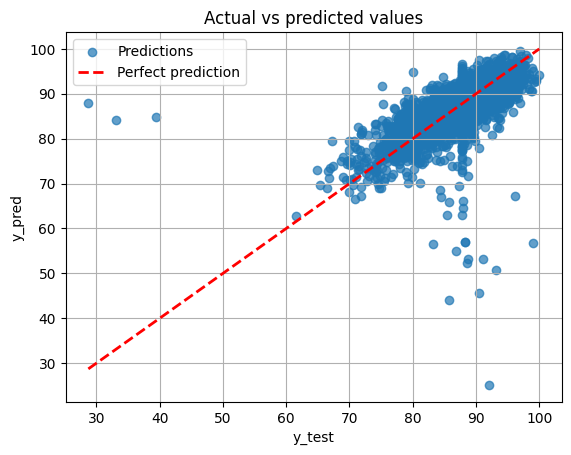

In [31]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты сильно хуже, чем у библиотечной модели.

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [32]:
def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    else:
        max_samples = None

    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': bootstrap,
        'max_samples': max_samples,
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-10 21:23:44,912] A new study created in memory with name: no-name-8677f8f5-0ddd-4e75-88a0-6535833987dd
[I 2025-12-10 21:23:46,073] Trial 0 finished with value: 4.41869712427517 and parameters: {'bootstrap': False, 'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'squared_error', 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 4.41869712427517.
[I 2025-12-10 21:23:58,992] Trial 1 finished with value: 4.625597476341452 and parameters: {'bootstrap': True, 'max_samples': 0.6061695553391381, 'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': None, 'criterion': 'absolute_error', 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 4.41869712427517.
[I 2025-12-10 21:24:40,842] Trial 2 finished with value: 4.647889860807484 and parameters: {'bootstrap': False, 'n_estimators': 247, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf':

Лучшие параметры для модели: {'bootstrap': True, 'max_samples': 0.7872394107999737, 'n_estimators': 93, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'absolute_error', 'random_state': 42, 'n_jobs': -1}
Лучшая метрика (root_mean_squared_error): 4.3756


In [33]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.2156
Model score for metric "root_mean_squared_error": 3.2334
Model score for metric "r2_score": 0.6726


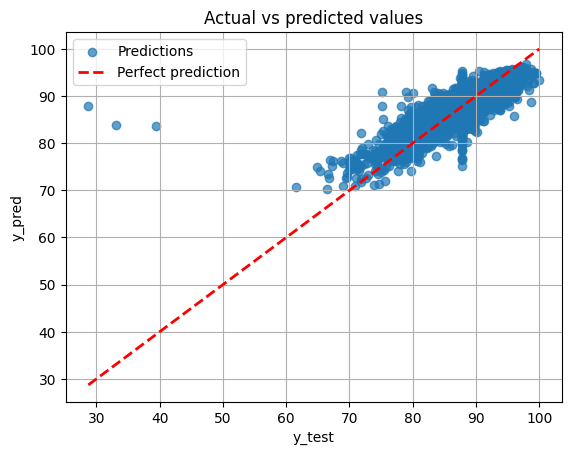

In [34]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты незначительно хуже чем у библиотечной модели, на сотые.

# Классификация

In [35]:
RAW_FEATS = 'classification_raw_feats.csv'
RAW_TARGET = 'classification_raw_target.csv'
PROCESSED_FEATS = 'classification_processed_feats.csv'
PROCESSED_TARGET = 'classification_processed_target.csv'

In [36]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [37]:
def evaluate(y_test, y_pred_class, y_pred_proba, round_num):

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"ROC AUC: {round(roc_auc,round_num)}", '\n')

    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)

    print(f"Precision: {round(precision,round_num)}")
    print(f"Recall: {round(recall,round_num)}")
    print(f"F1-Score: {round(f1,round_num)}")

    plt.plot(fpr, tpr, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

In [38]:
eval_metrics = [f1_score, roc_auc_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = f1_score
optuna_direction = "maximize"
n_trials = 30
cv = 3

max_depth = 10

## Готовая модель

In [39]:
model_class = RandomForestClassifier

### Бейзлайн

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [41]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [42]:
model = model_class(max_depth = max_depth, random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [43]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9737 

Precision: 0.937
Recall: 0.6636
F1-Score: 0.7769


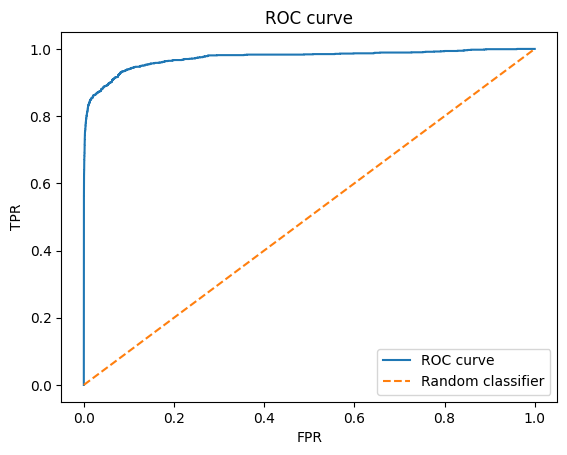

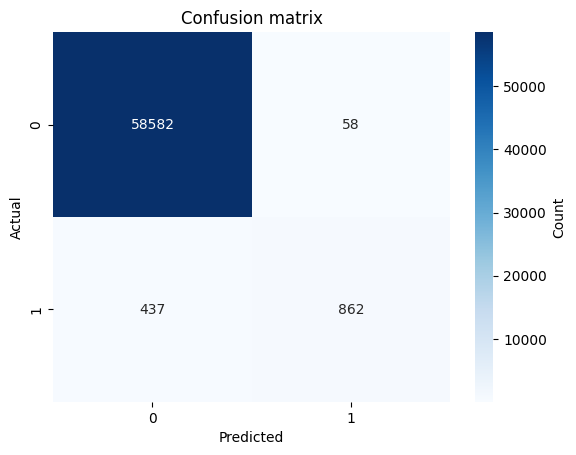

In [44]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [46]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [47]:
model = model_class(max_depth = max_depth, random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [48]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9791 

Precision: 0.9529
Recall: 0.7475
F1-Score: 0.8378


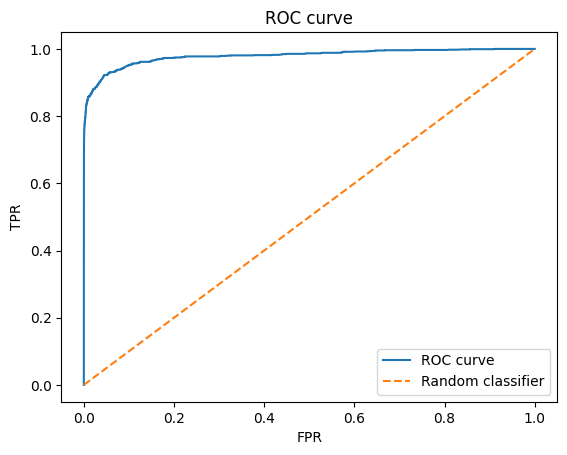

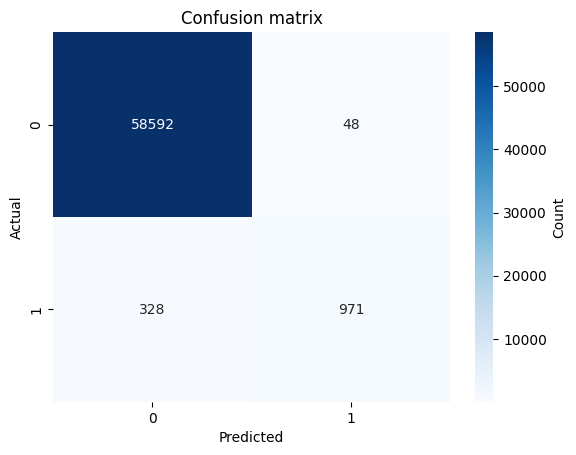

In [49]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [50]:
def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    else:
        max_samples = None

    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': bootstrap,
        'max_samples': max_samples,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-10 21:32:37,971] A new study created in memory with name: no-name-9f89d617-0142-417d-828b-7cb13b9f4d62
[I 2025-12-10 21:33:02,809] Trial 0 finished with value: 0.8284131370418698 and parameters: {'bootstrap': False, 'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.8284131370418698.
[I 2025-12-10 21:33:12,352] Trial 1 finished with value: 0.8259371921841855 and parameters: {'bootstrap': True, 'max_samples': 0.5917022549267169, 'n_estimators': 126, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.8284131370418698.
[I 2025-12-10 21:33:19,148] Trial 2 finished with value: 0.8285982328631428 and parameters: {'bootstrap': False, 'n_estimators': 61, 'max_depth': 10, 'min

Лучшие параметры для модели: {'bootstrap': False, 'n_estimators': 277, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None, 'random_state': 42, 'n_jobs': -1}
Лучшая метрика (f1_score): 0.8313


RandomForestClassifier(bootstrap=False, max_depth=15, max_features='log2',
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=277, n_jobs=-1, random_state=42)

In [51]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9786 

Precision: 0.9507
Recall: 0.7567
F1-Score: 0.8427


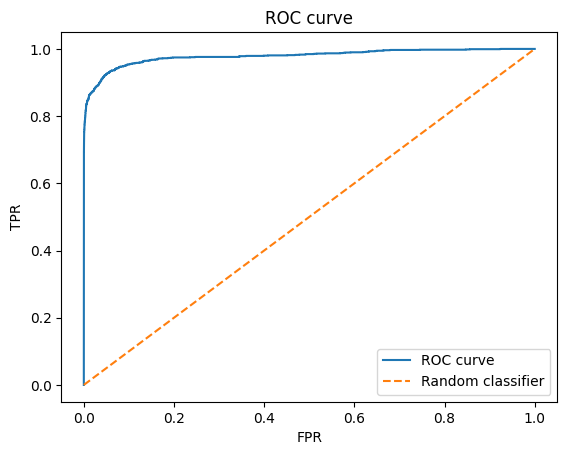

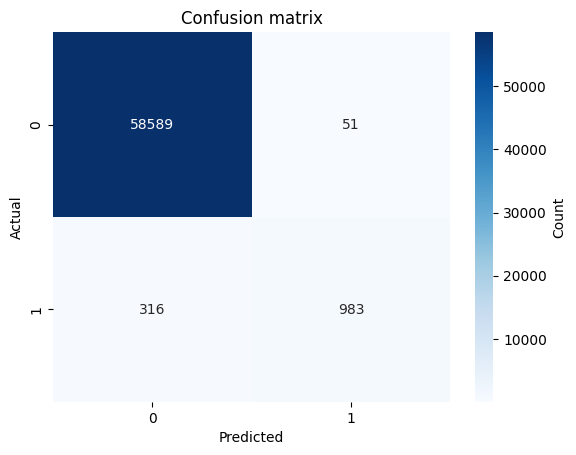

In [52]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

## Своя модель

In [ ]:
class MyRandomForestClassifier:
    """
    Parameters
    -----------
    n_estimators : int, default=100
    max_depth : int, default=None
    min_samples_split : int, default=2
    min_samples_leaf : int, default=1
    max_features : int, float, {"auto", "sqrt", "log2"} or None, default=None
    bootstrap : bool, default=True
    max_samples : int or float, default=None
    criterion : str, default="gini"
    class_weight : str, default = None
    random_state : int, default=None
    n_jobs : int, default=None
    """
    
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, 
            min_samples_leaf=1, max_features=None, bootstrap=True, 
            max_samples=None, criterion="gini", class_weight = None, random_state=None, n_jobs=None):
        
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.criterion = criterion
        self.random_state = random_state
        self.class_weight = class_weight
        self.n_jobs = n_jobs
        
        self.estimators_ = None
        self.n_features_ = None
        self.n_classes_ = None
        self.classes_ = None
        self.X_ = None
        self.y_ = None
        self.rng_ = None
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")
        
        self.X_ = X
        self.y_ = y
        self.n_features_ = X.shape[1]
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        self.rng_ = np.random.RandomState(self.random_state)
        
        self.estimators_ = []
        
        if self.max_features is None or self.max_features == "auto":
            max_features = self.n_features_
        elif self.max_features == "sqrt":
            max_features = max(1, int(np.sqrt(self.n_features_)))
        elif self.max_features == "log2":
            max_features = max(1, int(np.log2(self.n_features_)))
        elif isinstance(self.max_features, int):
            max_features = min(self.max_features, self.n_features_)
        elif isinstance(self.max_features, float):
            max_features = max(1, int(self.max_features * self.n_features_))
        
        if self.max_samples is None:
            max_samples = X.shape[0]
        elif isinstance(self.max_samples, int):
            max_samples = min(self.max_samples, X.shape[0])
        elif isinstance(self.max_samples, float):
            max_samples = max(1, int(self.max_samples * X.shape[0]))
        
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._build_tree)(
                max_features, max_samples, i
            ) for i in range(self.n_estimators)
        )
        
        return self
    
    def _build_tree(self, max_features, max_samples, tree_idx):
        tree = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            max_features=max_features,
            criterion=self.criterion,
            class_weight=self.class_weight,
            random_state=self.random_state + tree_idx if self.random_state is not None else None
        )
        
        if self.bootstrap:
            indices = self.rng_.choice(self.X_.shape[0], max_samples, replace=True)
        else:
            indices = self.rng_.choice(self.X_.shape[0], max_samples, replace=False)
        
        X_subset = self.X_[indices]
        y_subset = self.y_[indices]
        
        tree.fit(X_subset, y_subset)
        
        return tree
    
    def predict(self, X):
        if self.estimators_ is None:
            raise RuntimeError("You must call fit() before predict().")
        
        X = np.asarray(X)
        
        predictions = np.array([tree.predict(X) for tree in self.estimators_])
        
        y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        
        return y_pred

    def predict_proba(self, X):
        if self.estimators_ is None:
            raise RuntimeError("You must call fit() before predict_proba().")

        X = np.asarray(X)
        
        all_probas = np.array([tree.predict_proba(X) for tree in self.estimators_])
        
        avg_probas = np.mean(all_probas, axis=0)
        
        return avg_probas
    
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'bootstrap': self.bootstrap,
            'max_samples': self.max_samples,
            'criterion': self.criterion,
            'class_weight': self.class_weight,
            'random_state': self.random_state,
            'n_jobs': self.n_jobs
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyRandomForestClassifier")
        return self

In [54]:
model_class = MyRandomForestClassifier

### Бейзлайн

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [56]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [57]:
model = model_class(max_depth = max_depth, random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

In [58]:
y_pred_class = model.predict(X_test)

In [59]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9551 

Precision: 0.8976
Recall: 0.6813
F1-Score: 0.7746


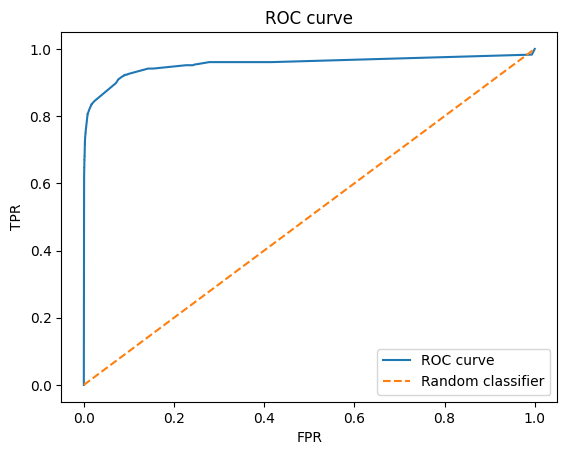

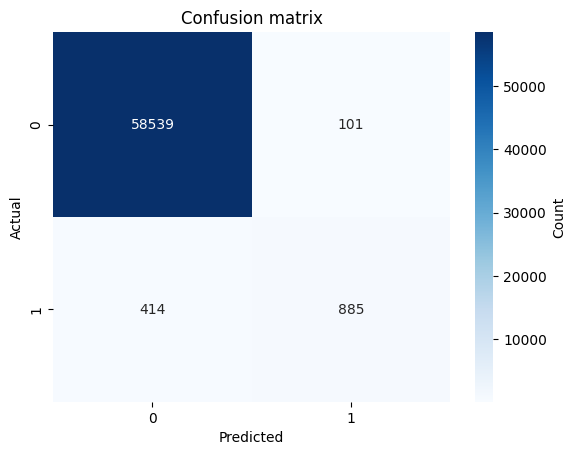

In [60]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результат приблизительно совпадает с библиотечной моделью.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [62]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [63]:
model = model_class(max_depth = max_depth, random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

In [64]:
y_pred_class = model.predict(X_test)

In [65]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9635 

Precision: 0.9277
Recall: 0.7413
F1-Score: 0.8241


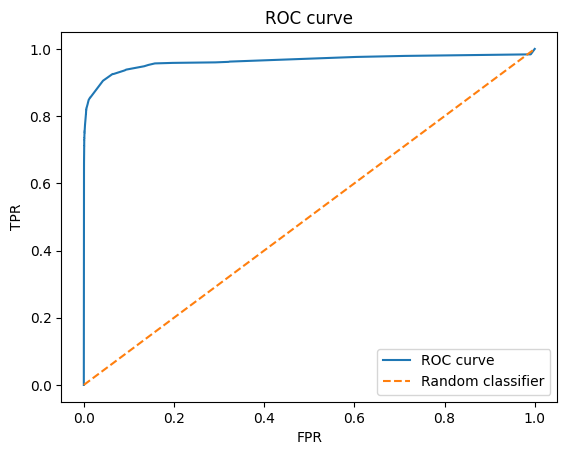

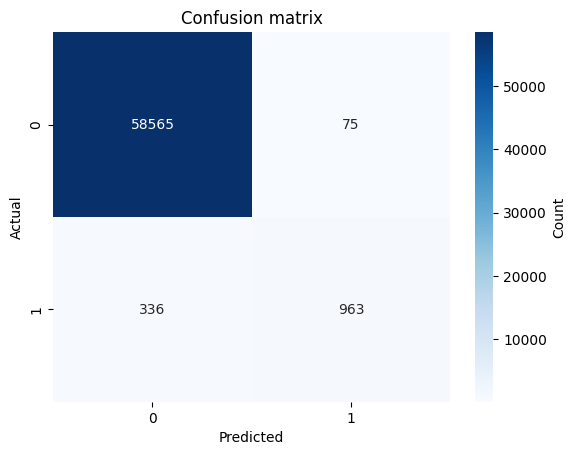

In [66]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результат незначительно хуже, чем у библиотечной модели (на сотые).

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [67]:
def objective(trial):
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    if bootstrap:
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    else:
        max_samples = None

    optuna_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': bootstrap,
        'max_samples': max_samples,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-10 21:51:18,030] A new study created in memory with name: no-name-61521b6e-4cd2-4c86-8a57-e377bb560125
[I 2025-12-10 21:51:55,195] Trial 0 finished with value: 0.827003646418356 and parameters: {'bootstrap': False, 'n_estimators': 233, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.827003646418356.
[I 2025-12-10 21:52:06,823] Trial 1 finished with value: 0.8214820071112525 and parameters: {'bootstrap': True, 'max_samples': 0.5917022549267169, 'n_estimators': 126, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy', 'class_weight': None, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.827003646418356.
[I 2025-12-10 21:52:17,040] Trial 2 finished with value: 0.8267035147341599 and parameters: {'bootstrap': False, 'n_estimators': 61, 'max_depth': 10, 'min_sa

Лучшие параметры для модели: {'bootstrap': False, 'n_estimators': 181, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'gini', 'class_weight': None, 'random_state': 42, 'n_jobs': -1}
Лучшая метрика (f1_score): 0.8307


In [68]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9788 

Precision: 0.9512
Recall: 0.7498
F1-Score: 0.8386


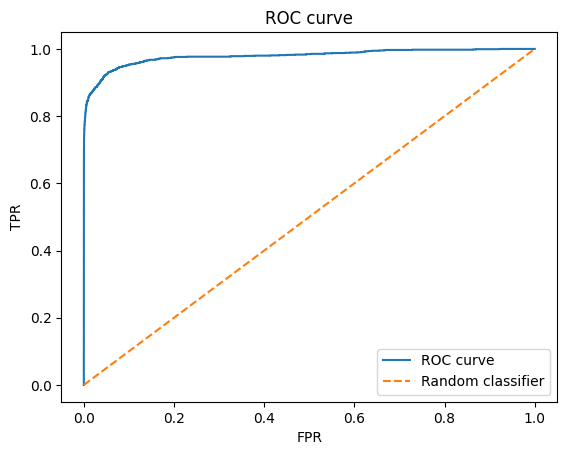

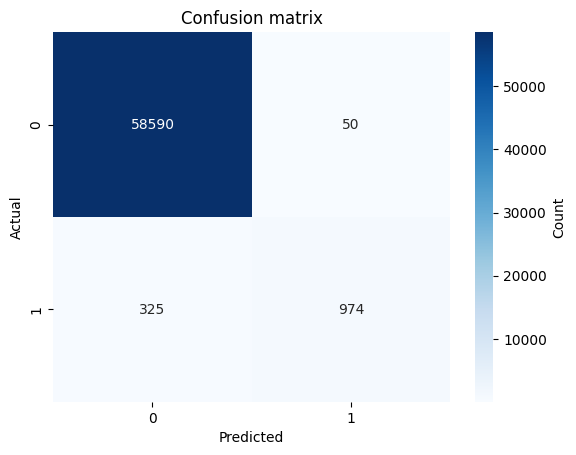

In [69]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результат идентичен с разностью на сотые-тысячные.

# Выводы

Кастомные реализации случайного леса из деревьев решений показали результаты, идентичные библиотечным моделям. Для оптимизации скорости обучения с учётом реализации деревьев решений в прошлой ЛР, в данной ЛР использовались библиотечные модели деревьев решений, которые объединялись через пользовательский код.

Предобработка данных и подбор гиперпараметров через Optuna с кросс-валидацией показали хороший прирост по метрикам для регресии, хотя по итогу кастомная модель проигрывает библиотечной. На классификации кастомная модель показала идентичный библиотечной результат.